### 総合演習データパイプライン

* 入力：CSVファイル ("C:\Users\Admin\ILP\Python-AI\raw_data.csv")
* FeatherL:C:\Users\81803\ILP\Python-AI\merged_data.feather
* 出力：

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 1. 指定支持日文的字体名称（前提是该字体已安装）
mpl.rcParams['font.family'] = 'MS Gothic'  
# 2. 关闭坐标轴负号显示为方块的问题
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
#必要なライブラリ
import pandas as pd
import numpy as np
import pyarrow.feather as feather
from sklearn.preprocessing import LabelEncoder

In [137]:
df = pd.read_csv('newrawdata.csv',encoding='utf-8')
df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)

df

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3434063758.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)


,日付,曜日,予約件数,予約人数,来客数,総杯数,売上合計(円),ペールエール(本),ペールエール(円),ラガー(本),ラガー(円),IPA(本),IPA(円),ホワイトビール(本),ホワイトビール(円),黒ビール(本),黒ビール(円),フルーツビール(本),フルーツビール(円)
0,2024-04-01,月,NaN,NaN,16,25,25300,6,6000,5,4000,5,4500,4,3600,6,7200,0,0
1,2024-04-02,火,NaN,NaN,19,25,24600,6,6000,4,3200,5,4500,3,2700,6,7200,1,1000
2,2024-04-03,水,NaN,NaN,11,19,18500,5,5000,4,3200,3,2700,2,1800,4,4800,1,1000
3,2024-04-04,木,NaN,NaN,6,10,9500,2,2000,2,1600,2,1800,1,900,1,1200,2,2000
4,2024-04-05,金,NaN,NaN,10,18,17100,3,3000,5,4000,3,2700,2,1800,3,3600,2,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2025-03-27,木,NaN,NaN,10,14,13400,2,2000,3,2400,2,1800,2,1800,2,2400,3,3000
310,2025-03-28,金,NaN,NaN,14,28,26900,6,6000,7,5600,3,2700,4,3600,5,6000,3,3000
311,2025-03-29,土,NaN,NaN,6,8,7600,2,2000,2,1600,1,900,1,900,1,1200,1,1000
312,2025-03-31,月,NaN,NaN,9,15,14800,4,4000,2,1600,2,1800,2,1800,3,3600,2,2000


In [14]:
import pandas as pd

df = pd.read_csv('./data/raw_data.csv', encoding='utf-8')

# 1. 过滤掉 '日付'、空行或其它异常值
mask = df['日付'].astype(str).str.match(r'^\d{4}/\d{1,2}/\d{1,2}$')
df = df.loc[mask].copy()

# 2. 解析为 datetime
df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)

# 3. 验证
print(df['日付'].head())
print(df.info())


0   2024-04-01
1   2024-04-02
2   2024-04-03
3   2024-04-04
4   2024-04-05
Name: 日付, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 0 to 325
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   日付          315 non-null    datetime64[ns]
 1   予約件数        28 non-null     object        
 2   予約人数        47 non-null     object        
 3   来客数         314 non-null    object        
 4   総杯数         314 non-null    object        
 5   売上合計(円)     313 non-null    object        
 6   ペールエール(本)   310 non-null    object        
 7   ペールエール(円)   310 non-null    object        
 8   ラガー(本)      307 non-null    object        
 9   ラガー(円)      307 non-null    object        
 10  IPA(本)      286 non-null    object        
 11  IPA(円)      285 non-null    object        
 12  ホワイトビール(本)  259 non-null    object        
 13  ホワイトビール(円)  257 non-null    object        
 14  黒ビール(本)     233 non-

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2808381903.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)


In [15]:
# 定义包含各品类销售额的列名
sales_cols = [
    'ペールエール(円)',
    'ラガー(円)',
    'IPA(円)',
    'ホワイトビール(円)',
    '黒ビール(円)',
    'フルーツビール(円)'
]

# 去掉千分位逗号并转成数值
for col in sales_cols + ['売上合計(円)']:
    df[col] = (
        df[col]
        .fillna('0')            # 将 NaN 当作 "0" 处理
        .astype(str)
        .str.replace(',', '')   # 移除逗号
        .astype(float)          # 转为 float
    )

# 重新计算総売上額
df['総売上額'] = df[sales_cols].sum(axis=1)

# 查看原始合计和重新计算的对比
print(df[['日付', '売上合計(円)', '総売上額']].head())


          日付  売上合計(円)     総売上額
0 2024-04-01  31800.0  31800.0
1 2024-04-02  23300.0  23300.0
2 2024-04-03  33600.0  33600.0
3 2024-04-04  24600.0  24600.0
4 2024-04-05  56500.0  56500.0


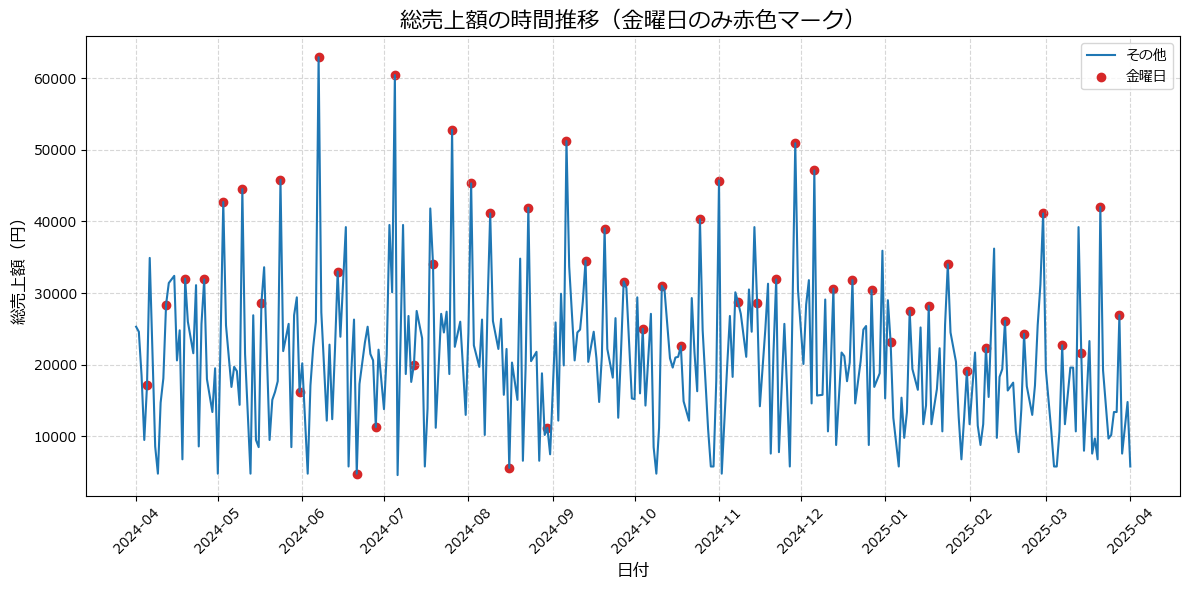

In [132]:
# ...existing code...
dates = df['日付']
sales = df['売上合計(円)']
friday_mask = dates.dt.weekday == 4  # 金曜日のみ

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, sales, linestyle='-', label='その他', color='tab:blue')
ax.scatter(dates[friday_mask], sales[friday_mask],
           color='tab:red', marker='o', label='金曜日')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.legend()
ax.set_title('総売上額の時間推移（金曜日のみ赤色マーク）', fontsize=16)
ax.set_xlabel('日付', fontsize=12)
ax.set_ylabel('総売上額（円）', fontsize=12)

ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# ...existing code...

In [188]:
mergeddf.to_json('mergeddf.json', orient='records', force_ascii=False, indent=4)
mergeddf.to_feather('mergeddf.feather')

In [26]:
df = feather.read_feather('mergeddf.feather')
df.columns.unique()

Index(['日付', '曜日', '来客数', '総杯数', '売上合計(円)', 'ペールエール(本)', 'ペールエール(円)_x',
       'ラガー(本)', 'ラガー(円)_x', 'IPA(本)', 'IPA(円)_x', 'ホワイトビール(本)',
       'ホワイトビール(円)_x', '黒ビール(本)', '黒ビール(円)_x', 'フルーツビール(本)', 'フルーツビール(円)_x',
       '平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)', '平均湿度(％)', '最高気温(℃)', '最低気温(℃)',
       '10分間降水量の最大(mm)', '天気概況(昼：06時～18時)', '天気概況(夜：18時～翌日06時)'],
      dtype='object')

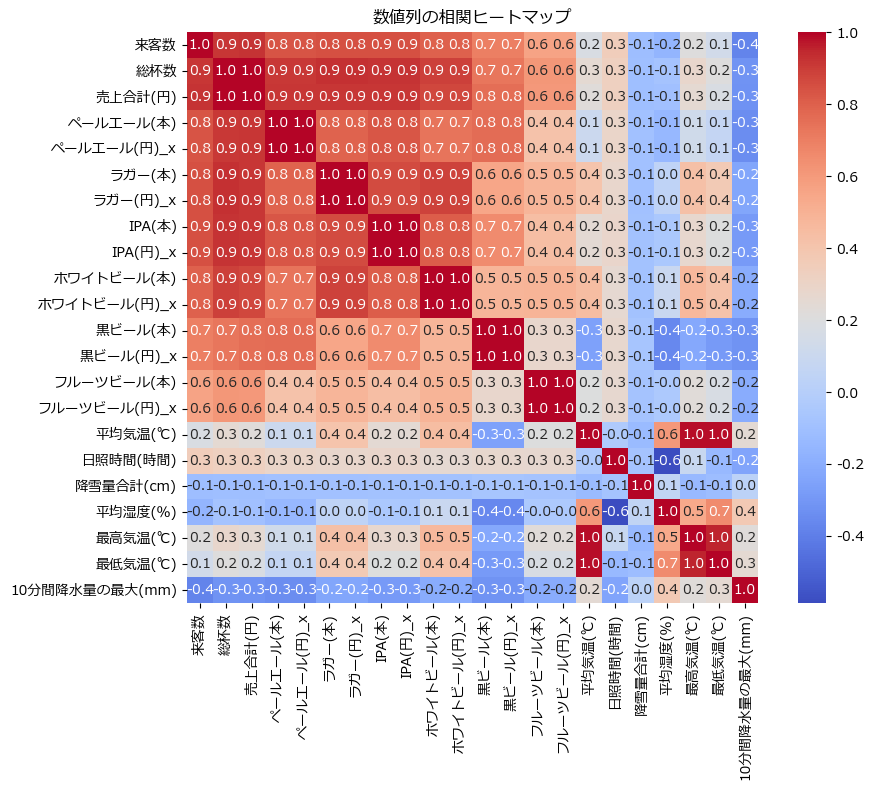

In [191]:
# ...existing code...
import seaborn as sns
import matplotlib.pyplot as plt

# 数値列のみ抽出
corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', square=True)
plt.title('数値列の相関ヒートマップ')
plt.tight_layout()
plt.show()
# ...existing code...

In [27]:
df['date'] = pd.to_datetime(df['日付'])
df = df.sort_values('date')
df['weekday']    = df['date'].dt.weekday        # 0=周一…6=周日  
df['is_weekend'] = df['weekday'] >= 5            # 周末标记  
df['month']      = df['date'].dt.month  
df['dayofyear']  = df['date'].dt.dayofyear  


In [194]:
beer_list = [
    'ペールエール(本)',
    'ラガー(本)',
    'IPA(本)',
    'ホワイトビール(本)',
    '黒ビール(本)',
    'フルーツビール(本)'
]
for beer in beer_list:
    df[f'{beer}_lag1'] = df[beer].shift(1)
    df[f'{beer}_ma7']  = df[beer].rolling(7).mean().shift(1)


In [195]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)


In [206]:
import pandas as pd
import numpy as np
import jpholiday
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. 读取数据
# 根据实际情况修改路径与格式
# df = pd.read_csv('mergeddf.csv', parse_dates=['日付'])
df = pd.read_feather('mergeddf.feather')

# 2. 构造日期特征与节假日
df['日付']      = pd.to_datetime(df['日付'])
df['weekday']   = df['日付'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month']     = df['日付'].dt.month
df['dayofyear'] = df['日付'].dt.dayofyear
# 日本法定节假日
df['is_holiday'] = df['日付'].apply(lambda x: int(jpholiday.is_holiday(x)))

# 3. 气象特征与缺失值处理
weather_cols = [
    '平均気温(℃)', '最高気温(℃)', '最低気温(℃)',
    '10分間降水量の最大(mm)', '日照時間(時間)', '平均湿度(％)'
]
df[weather_cols] = SimpleImputer(strategy='mean').fit_transform(df[weather_cols])

# 4. 定义特征列和目标列
target_cols = [
    'ペールエール(本)', 'ラガー(本)', 'IPA(本)',
    'ホワイトビール(本)', '黒ビール(本)', 'フルーツビール(本)'
]
feature_cols = [
    'weekday', 'is_weekend', 'month', 'dayofyear', 'is_holiday'
] + weather_cols

X = df[feature_cols]
y = df[target_cols]

# 5. 缺失值填充和标准化
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 6. 时序交叉验证与 MLPRegressor 网格搜索
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [1e-3, 1e-2]
}
mlp = MLPRegressor(random_state=42, max_iter=500)
grid = GridSearchCV(
    mlp, param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_scaled, y)
print("Best parameters:", grid.best_params_)

# 7. 留最后 30 天做测试评估
X_train, X_test = X_scaled[:-30], X_scaled[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]
best_mlp = grid.best_estimator_
best_mlp.fit(X_train, y_train)
y_pred = best_mlp.predict(X_test)

# 8. 输出评估结果
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"Test R2 : {r2_score(y_test, y_pred):.3f}")


c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Test MSE: 3.384
Test R2 : 0.172


c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
import pandas as pd
import numpy as np
import jpholiday
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. 读取数据
# 根据实际情况修改路径与格式
# df = pd.read_csv('mergeddf.csv', parse_dates=['日付'])
df = pd.read_feather('mergeddf.feather')

# 2. 构造日期特征与节假日
df['日付']      = pd.to_datetime(df['日付'])
df['weekday']   = df['日付'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month']     = df['日付'].dt.month
df['dayofyear'] = df['日付'].dt.dayofyear
# 日本法定节假日
df['is_holiday'] = df['日付'].apply(lambda x: int(jpholiday.is_holiday(x)))

# 3. 主要气象特征与缺失值处理
weather_cols = [
    '10分間降水量の最大(mm)', '日照時間(時間)', '平均湿度(％)'
]
df[weather_cols] = SimpleImputer(strategy='mean').fit_transform(df[weather_cols])

# 4. 计算总销售量作为单一目标
target_cols = [
    'ペールエール(本)', 'ラガー(本)', 'IPA(本)',
    'ホワイトビール(本)', '黒ビール(本)', 'フルーツビール(本)'
]
df['total_sales'] = df[target_cols].sum(axis=1)

# 5. 准备特征矩阵和目标向量
feature_cols = [
    'weekday', 'is_weekend', 'month', 'dayofyear', 'is_holiday'
] + weather_cols
X = df[feature_cols]
y = df['total_sales']

# 6. 特征预处理：填补 & 标准化
X_imp = SimpleImputer(strategy='mean').fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imp)

# 7. 时序交叉验证与神经网络网格搜索
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [1e-3, 1e-2]
}
mlp = MLPRegressor(random_state=42, max_iter=500)
grid = GridSearchCV(
    mlp, param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_scaled, y)
print("Best parameters:", grid.best_params_)

# 8. 最后 30 天做测试评估
X_train, X_test = X_scaled[:-30], X_scaled[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]
best_mlp = grid.best_estimator_
best_mlp.fit(X_train, y_train)
y_pred = best_mlp.predict(X_test)

# 9. 输出评估结果
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"Test R2 : {r2_score(y_test, y_pred):.3f}")


c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}
Test MSE: 86.864
Test R2 : 0.244


c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


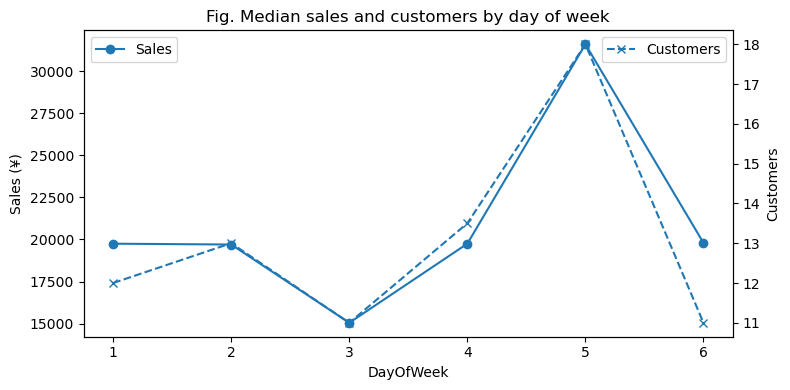

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取数据
df = pd.read_feather('mergeddf.feather')

# 2. 确保日期列为 datetime，并提取星期几（1=星期一,…,7=星期日）
df['日付'] = pd.to_datetime(df['日付'])
df['DayOfWeek'] = df['日付'].dt.weekday + 1

# 3. 计算中位数
median_sales     = df.groupby('DayOfWeek')['売上合計(円)'].median()
median_customers = df.groupby('DayOfWeek')['来客数'].median()

# 4. 绘图
fig, ax1 = plt.subplots(figsize=(8, 4))

# 左轴：销售额
ax1.plot(median_sales.index,
         median_sales.values,
         marker='o',
         label='Sales')
ax1.set_xlabel('DayOfWeek')
ax1.set_ylabel('Sales (¥)')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# 右轴：来客数
ax2 = ax1.twinx()
ax2.plot(median_customers.index,
         median_customers.values,
         marker='x',
         linestyle='--',
         label='Customers')
ax2.set_ylabel('Customers')
ax2.legend(loc='upper right')

# 标题 & 美化
plt.title('Fig. Median sales and customers by day of week')
plt.tight_layout()
plt.show()


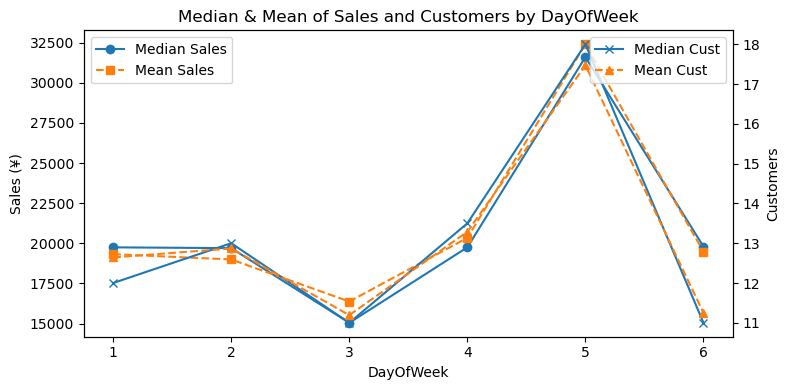

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取数据
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df['DayOfWeek'] = df['日付'].dt.weekday + 1

# 2. 计算中位数和平均数
grp = df.groupby('DayOfWeek')
median_sales     = grp['売上合計(円)'].median()
mean_sales       = grp['売上合計(円)'].mean()
median_customers = grp['来客数'].median()
mean_customers   = grp['来客数'].mean()

# 3. 绘图
fig, ax1 = plt.subplots(figsize=(8, 4))

# 销售额：中位数和平均数
ax1.plot(median_sales.index, median_sales.values,   marker='o', label='Median Sales')
ax1.plot(mean_sales.index,   mean_sales.values,     marker='s', linestyle='--', label='Mean Sales')
ax1.set_xlabel('DayOfWeek')
ax1.set_ylabel('Sales (¥)')
ax1.legend(loc='upper left')

# 来客数：中位数和平均数
ax2 = ax1.twinx()
ax2.plot(median_customers.index, median_customers.values, marker='x', label='Median Cust')
ax2.plot(mean_customers.index,   mean_customers.values,   marker='^', linestyle='--', label='Mean Cust')
ax2.set_ylabel('Customers')
ax2.legend(loc='upper right')

plt.title('Median & Mean of Sales and Customers by DayOfWeek')
plt.tight_layout()
plt.show()


C:\Users\81803\AppData\Local\Temp\ipykernel_10852\1188712971.py:47: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\1188712971.py:47: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\1188712971.py:47: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\env

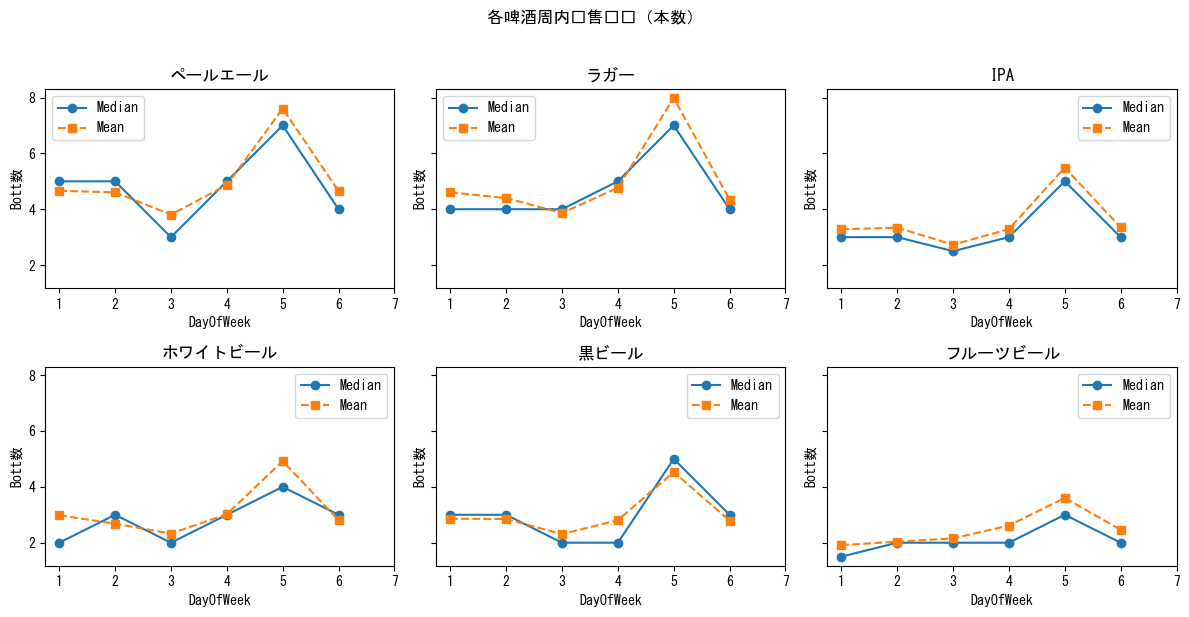

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读数据并生成 DayOfWeek
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df['DayOfWeek'] = df['日付'].dt.weekday + 1   # 1=周一…7=周日

# 2. 定义啤酒品类（对应“本”列）
beer_list = [
    'ペールエール',
    'ラガー',
    'IPA',
    'ホワイトビール',
    '黒ビール',
    'フルーツビール'
]

# 3. 绘制 2×3 子图
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
for ax, beer in zip(axes.flatten(), beer_list):
    col = f'{beer}(本)'
    grp = df.groupby('DayOfWeek')[col]
    
    median_vals = grp.median()
    mean_vals   = grp.mean()
    
    # 中位数
    ax.plot(median_vals.index, 
            median_vals.values,
            marker='o',
            label='Median')
    # 平均数
    ax.plot(mean_vals.index,
            mean_vals.values,
            marker='s',
            linestyle='--',
            label='Mean')
    
    ax.set_title(beer)
    ax.set_xlabel('DayOfWeek')
    ax.set_ylabel('Bott数')
    ax.set_xticks(range(1,8))
    ax.legend()

plt.suptitle('各啤酒周内销售趋势（本数）', y=1.02)
plt.tight_layout()
plt.show()


C:\Users\81803\AppData\Local\Temp\ipykernel_10852\3596392396.py:58: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\3596392396.py:58: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\3596392396.py:58: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\env

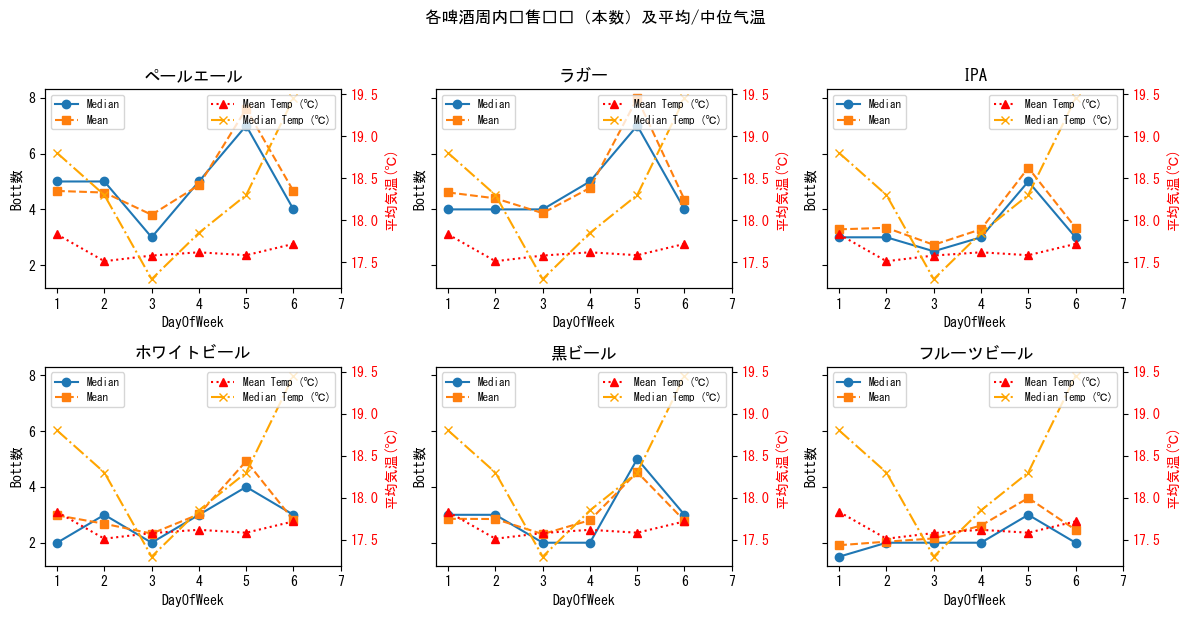

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读数据并生成 DayOfWeek
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df['DayOfWeek'] = df['日付'].dt.weekday + 1   # 1=周一…7=周日

# 2. 定义啤酒品类（对应“本”列）
beer_list = [
    'ペールエール',
    'ラガー',
    'IPA',
    'ホワイトビール',
    '黒ビール',
    'フルーツビール'
]

# 3. 计算每周的平均气温和中位气温
mean_temp = df.groupby('DayOfWeek')['平均気温(℃)'].mean()
median_temp = df.groupby('DayOfWeek')['平均気温(℃)'].median()

# 4. 绘制 2×3 子图
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
for ax, beer in zip(axes.flatten(), beer_list):
    col = f'{beer}(本)'
    grp = df.groupby('DayOfWeek')[col]
    
    median_vals = grp.median()
    mean_vals   = grp.mean()
    
    # 中位数
    ax.plot(median_vals.index, 
            median_vals.values,
            marker='o',
            label='Median')
    # 平均数
    ax.plot(mean_vals.index,
            mean_vals.values,
            marker='s',
            linestyle='--',
            label='Mean')
    # 平均气温（右轴）
    ax2 = ax.twinx()
    ax2.plot(mean_temp.index, mean_temp.values, color='red', marker='^', linestyle=':', label='Mean Temp (℃)')
    ax2.plot(median_temp.index, median_temp.values, color='orange', marker='x', linestyle='-.', label='Median Temp (℃)')
    ax2.set_ylabel('平均気温(℃)', color='red', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax.set_title(beer)
    ax.set_xlabel('DayOfWeek')
    ax.set_ylabel('Bott数')
    ax.set_xticks(range(1,8))
    ax.legend(loc='upper left', fontsize=8)
    ax2.legend(loc='upper right', fontsize=8)

plt.suptitle('各啤酒周内销售趋势（本数）及平均/中位气温', y=1.02)
plt.tight_layout()
plt.show()

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:47: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:47: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:47: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:47: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:47: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24635 

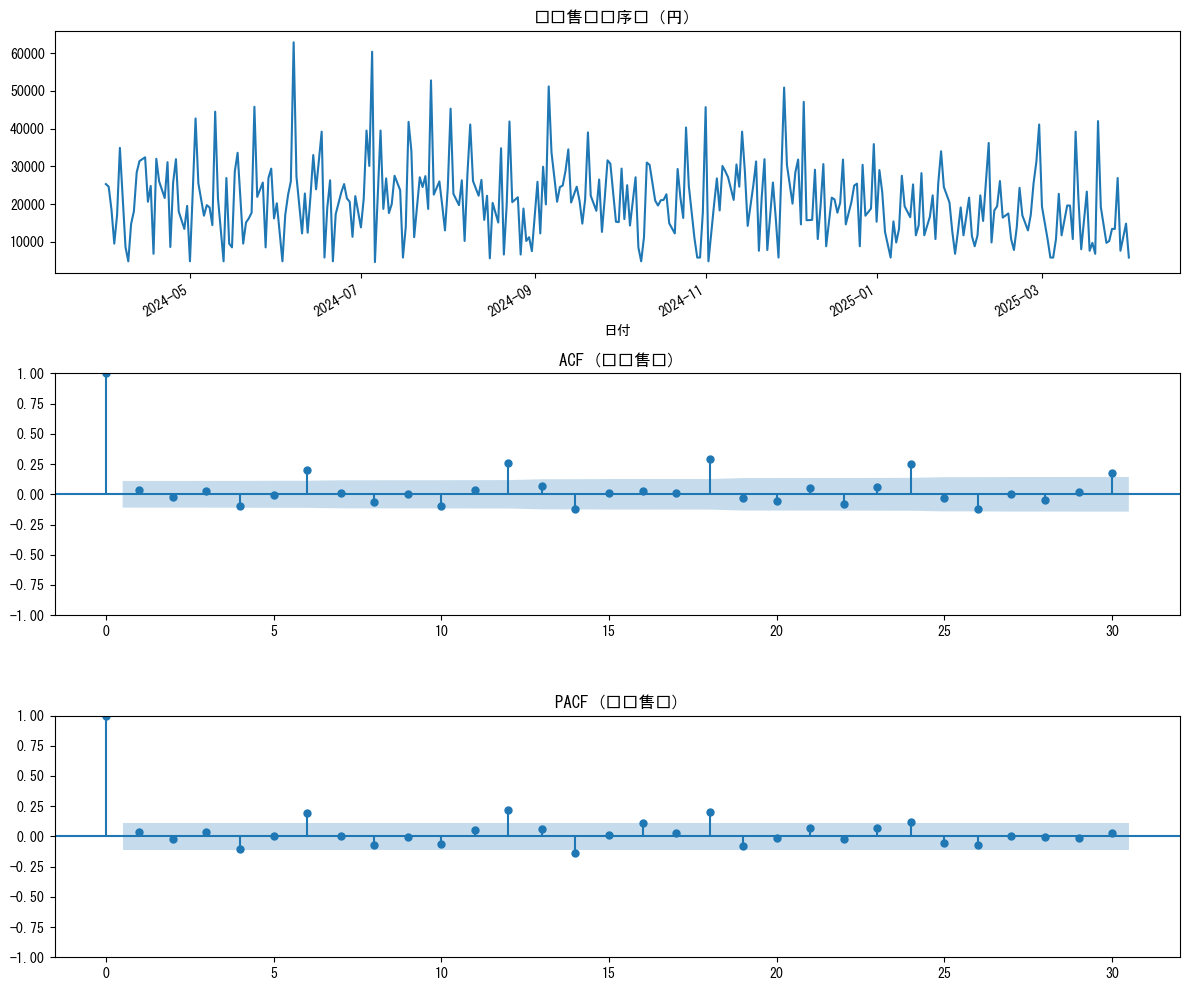

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:56: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:56: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


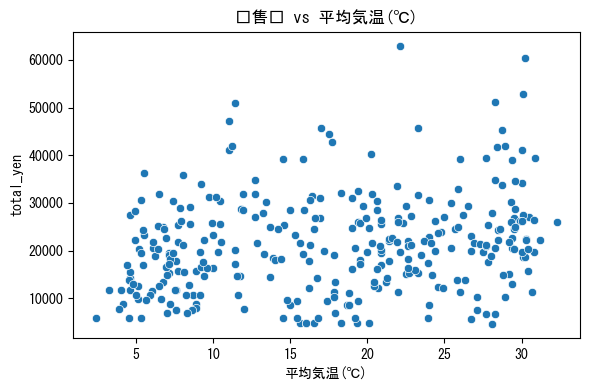

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:64: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:64: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


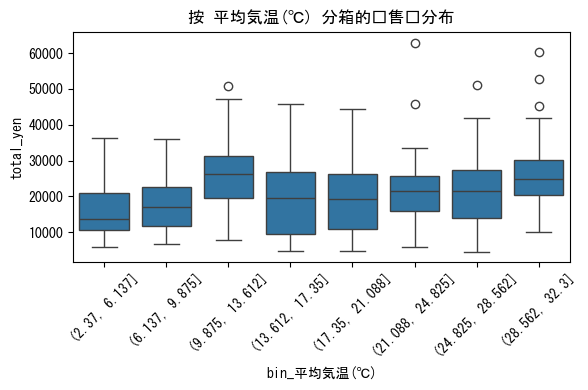

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:56: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:56: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


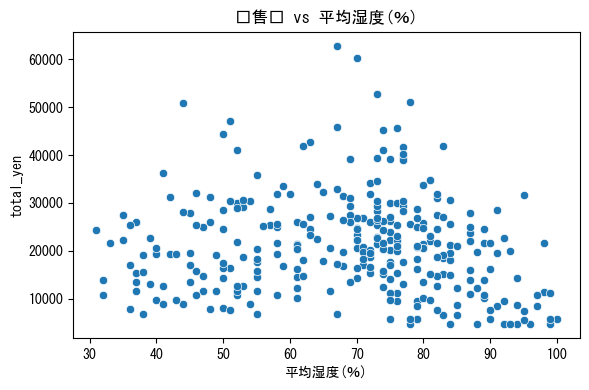

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:64: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:64: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


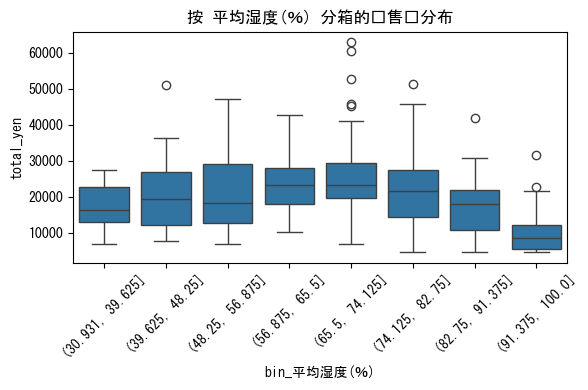

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:56: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:56: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


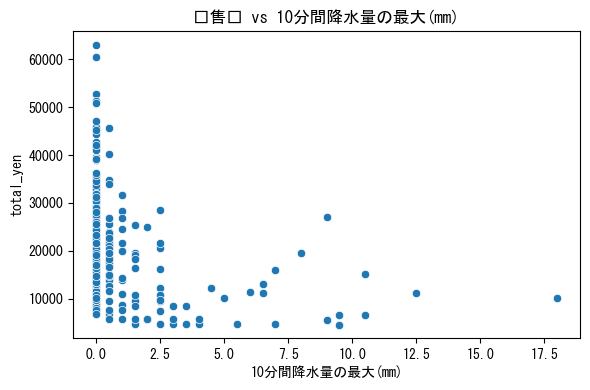

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:64: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:64: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


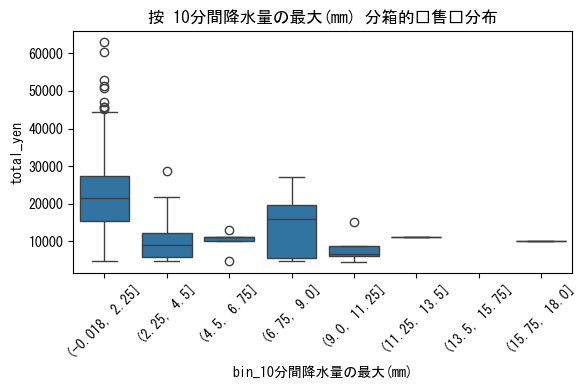

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:76: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:76: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:76: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\I

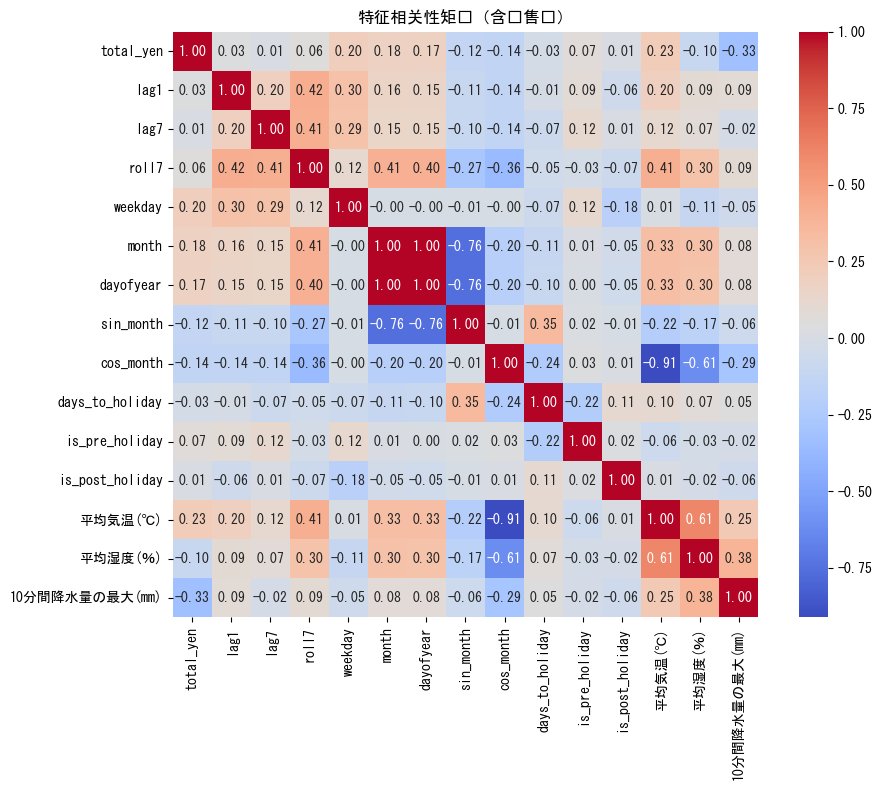

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:83: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:83: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


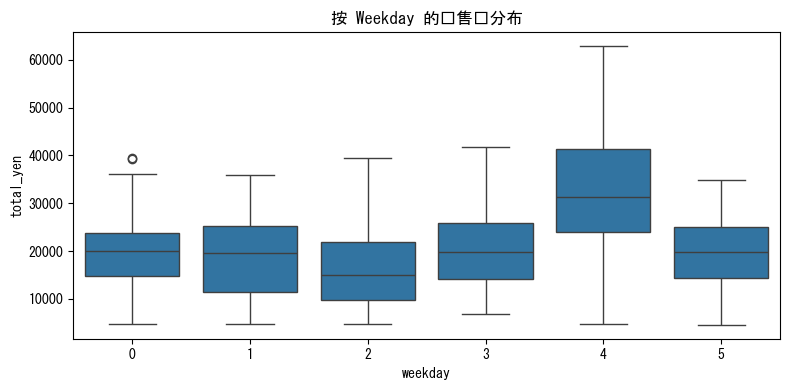

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:89: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:89: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


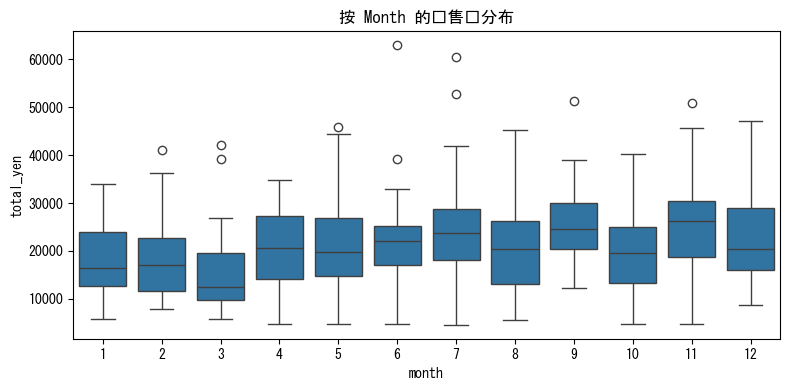

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:98: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:98: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:98: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\128001358.py:98: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylab

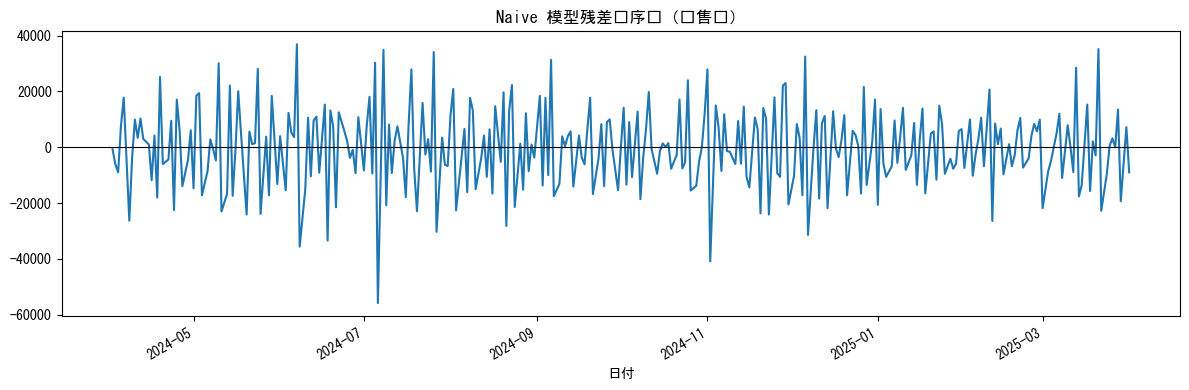

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# —— 0. 读取数据并准备“总销售额（円）”列 —— 
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df.set_index('日付', inplace=True)
df = df[~df.index.duplicated(keep='first')]

# 直接使用你已有的“売上合計(円)”列
df['total_yen'] = df['売上合計(円)']

# —— 1. 构造时序特征 —— 
df['lag1']   = df['total_yen'].shift(1)
df['lag7']   = df['total_yen'].shift(7)
df['roll7']  = df['total_yen'].rolling(7).mean().shift(1)
df['weekday']   = df.index.weekday
df['month']     = df.index.month
df['dayofyear'] = df.index.dayofyear
# 周期编码
df['sin_month'] = np.sin(2*np.pi*(df['month']-1)/12)
df['cos_month'] = np.cos(2*np.pi*(df['month']-1)/12)
# 距离下一个节假日天数
def days_to_holiday(d):
    for i in range(1,366):
        if jpholiday.is_holiday(d + pd.Timedelta(days=i)):
            return i
    return np.nan
df['days_to_holiday'] = df.index.to_series().apply(days_to_holiday)
# 节假日前/后
df['is_pre_holiday']  = (df['days_to_holiday']==1).astype(int)
df['is_post_holiday'] = df.index.to_series().apply(
    lambda d: int(jpholiday.is_holiday(d - pd.Timedelta(days=1)))
)

# —— 2. （1）总销售额时序图 + ACF/PACF —— 
fig, axes = plt.subplots(3,1, figsize=(12,10))
df['total_yen'].plot(ax=axes[0], title='总销售额时序图（円）')
plot_acf(df['total_yen'].dropna(), ax=axes[1], lags=30)
axes[1].set_title('ACF (总销售额)')
plot_pacf(df['total_yen'].dropna(), ax=axes[2], lags=30)
axes[2].set_title('PACF (总销售额)')
plt.tight_layout()
plt.show()

# —— 3. （2）销售额 vs 气温/湿度/降水 的散点图 & 箱线图 —— 
weather_cols = ['平均気温(℃)', '平均湿度(％)', '10分間降水量の最大(mm)']
for col in weather_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='total_yen', data=df)
    plt.title(f'销售额 vs {col}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(6,4))
    df[f'bin_{col}'] = pd.cut(df[col], bins=8)
    sns.boxplot(x=f'bin_{col}', y='total_yen', data=df)
    plt.xticks(rotation=45)
    plt.title(f'按 {col} 分箱的销售额分布')
    plt.tight_layout()
    plt.show()

# —— 4. （3）相关性热力图 —— 
feat_for_corr = [
    'total_yen','lag1','lag7','roll7','weekday','month','dayofyear',
    'sin_month','cos_month','days_to_holiday','is_pre_holiday','is_post_holiday'
] + weather_cols
corr = df[feat_for_corr].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('特征相关性矩阵（含销售额）')
plt.tight_layout()
plt.show()

# —— 5. （4）不同 Weekday/Month 的销售额箱线图 —— 
plt.figure(figsize=(8,4))
sns.boxplot(x='weekday', y='total_yen', data=df)
plt.title('按 Weekday 的销售额分布')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='month', y='total_yen', data=df)
plt.title('按 Month 的销售额分布')
plt.tight_layout()
plt.show()

# —— 6. （5）残差时序图示例（Naive 模型） —— 
df['naive_pred'] = df['total_yen'].shift(1)
df['residual'] = df['total_yen'] - df['naive_pred']
plt.figure(figsize=(12,4))
df['residual'].plot(title='Naive 模型残差时序图（销售额）')
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


### test

(273, 27) (273,) (30, 27) (30,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 93, number of used features: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 24
[LightGBM] [Info] Auto-choosing col-wise mult

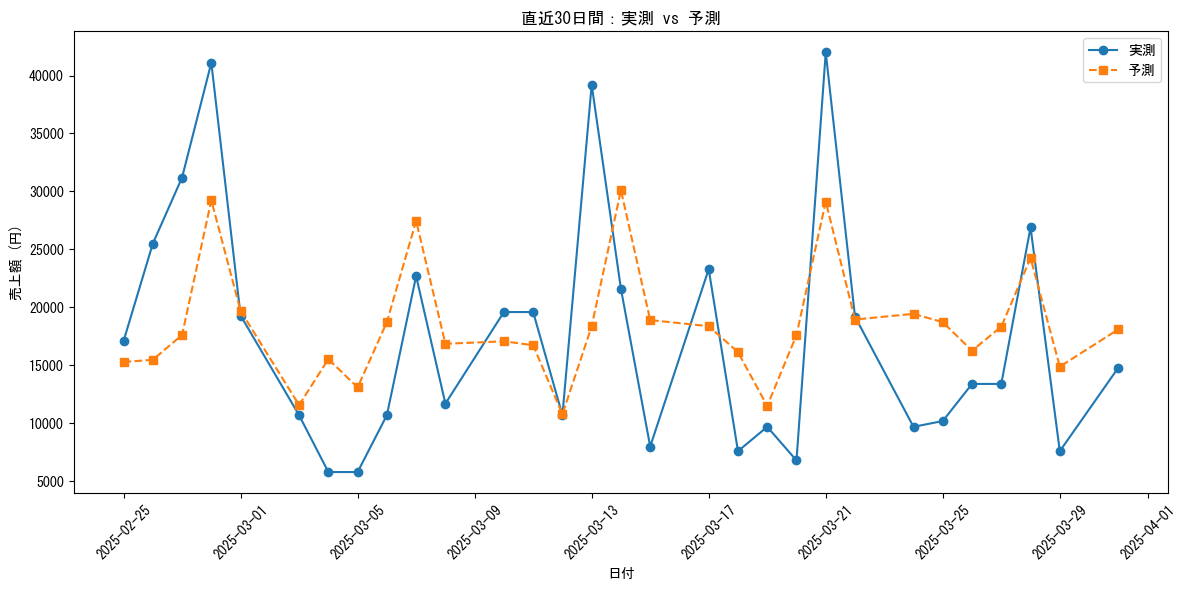

In [60]:
import warnings
import pandas as pd
import numpy as np
import jpholiday
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 警告抑制：TimeSeriesSplit が groups パラメータを無視する旨
warnings.filterwarnings(
    'ignore',
    message='The groups parameter is ignored by TimeSeriesSplit'
)

# 1. データの読み込みとインデックス設定
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df.set_index('日付', inplace=True)

# 2. 目的変数と基本的な日時特徴量の作成
df['total_yen']  = df['売上合計(円)']                        # 売上合計（円）
df['weekday']    = df.index.weekday                         # 0=月曜…6=日曜
df['is_weekend'] = (df['weekday'] >= 5).astype(int)         # 週末フラグ
df['is_friday']  = (df['weekday'] == 4).astype(int)         # 金曜フラグ
df['month']      = df.index.month                           # 月
df['dayofyear']  = df.index.dayofyear                       # 年内通し日
df['is_holiday'] = df.index.to_series().apply(lambda d: int(jpholiday.is_holiday(d)))  # 祝日フラグ

# 3. 遅延特徴量と移動平均特徴量の作成
for lag in [1, 2, 3, 7, 14]:
    df[f'lag_{lag}'] = df['total_yen'].shift(lag)
df['roll_3']   = df['total_yen'].rolling(3).mean().shift(1)
df['roll_7']   = df['total_yen'].rolling(7).mean().shift(1)
df['roll_14']  = df['total_yen'].rolling(14).mean().shift(1)
df['max_7']    = df['total_yen'].rolling(7).max().shift(1)  # 過去7日間の最大値
df['min_7']    = df['total_yen'].rolling(7).min().shift(1)  # 過去7日間の最小値

# 4. 周期性エンコーディング（年次/週次）
df['sin_month']   = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['cos_month']   = np.cos(2 * np.pi * (df['month'] - 1) / 12)
df['sin_weekday'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['cos_weekday'] = np.cos(2 * np.pi * df['weekday'] / 7)

# 5. 気象特徴量と非線形・二値化特徴量の作成
df['rain_flag']    = (df['10分間降水量の最大(mm)'] > 0).astype(int)    # 降水フラグ
df['heavy_rain']   = (df['10分間降水量の最大(mm)'] > 5).astype(int)    # 大雨フラグ
df['temp2']        = df['平均気温(℃)'] ** 2                           # 気温の二乗
df['weekend_rain'] = df['is_weekend'] * df['rain_flag']               # 週末×降水フラグ

# 6. 目的変数に log1p 変換
df['log_yen'] = np.log1p(df['total_yen'])

# 7. NaN を含む行の削除
feature_cols = [
    'weekday','is_weekend','is_friday','month','dayofyear','is_holiday',
    *[f'lag_{l}' for l in [1,2,3,7,14]],
    'roll_3','roll_7','roll_14','max_7','min_7',
    'sin_month','cos_month','sin_weekday','cos_weekday',
    '平均気温(℃)','平均湿度(％)','10分間降水量の最大(mm)',
    'rain_flag','heavy_rain','weekend_rain','temp2'
]
df_model = df.dropna(subset=feature_cols + ['log_yen'])

# 8. 訓練データとテストデータの分割
X = df_model[feature_cols]
y = df_model['log_yen']

X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)
# 9. 時系列 CV による最適イテレーション数の決定
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
}
# スプリットを事前にリスト化して渡す
tscv   = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X_train))
lgb_train = lgb.Dataset(X_train, label=y_train)
cv_res = lgb.cv(
    lgb_params,
    lgb_train,
    folds=splits,
    num_boost_round=2000,
    metrics='rmse',
    seed=42,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# メトリック名を自動取得して早期停止後の最適イテレーション数を決定
mean_keys = [k for k in cv_res.keys() if k.endswith('-mean')]
metric_name = mean_keys[0]  # 通常は ['rmse-mean'] など
best_round = len(cv_res[metric_name])
print(f"訓練データ CV ({metric_name}) による最適イテレーション数：{best_round}")

# 10. 最終モデルの訓練
final_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=best_round
)

# 11. テストデータで予測し逆変換
y_pred_log  = final_model.predict(X_test)
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_log)

# 12. 評価
print("テストデータ（元の単位）評価：")
print(" R2   =", r2_score(y_test_orig, y_pred_orig))
print(" RMSE =", np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)))

# 13. 結果の可視化
plt.figure(figsize=(12,6))
dates = df_model.index[-30:]
plt.plot(dates, y_test_orig, 'o-', label='実測')
plt.plot(dates, y_pred_orig, 's--', label='予測')
plt.xlabel('日付')
plt.ylabel('売上額 (円)')
plt.title('直近30日間：実測 vs 予測')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 21
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 93, number of used features: 21
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 21
[LightGBM] [Info

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\2646997360.py:126: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\2646997360.py:126: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\2646997360.py:126: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\2646997360.py:126: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\2646997360.py:126: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Gl

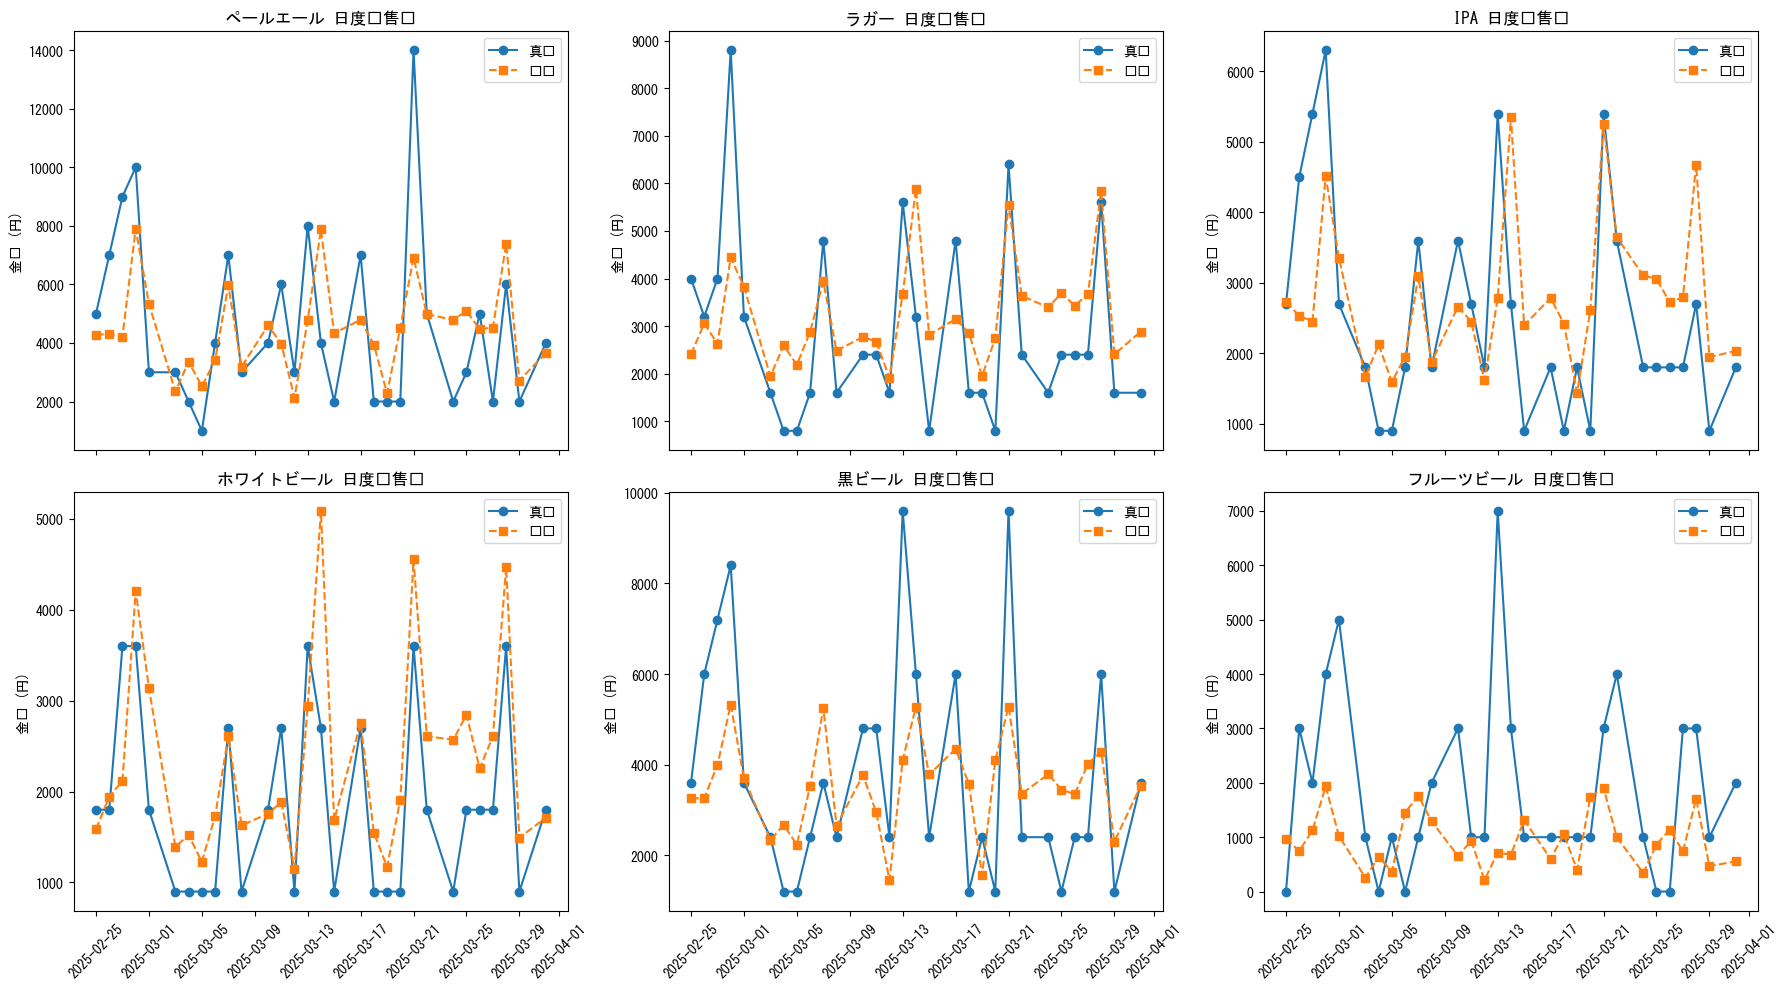

In [65]:
import warnings
import pandas as pd
import numpy as np
import jpholiday
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 屏蔽 TimeSeriesSplit 忽略 groups 参数的警告
warnings.filterwarnings(
    'ignore',
    message='The groups parameter is ignored by TimeSeriesSplit'
)

# 1. 读取原始日度数据并设置索引
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df.set_index('日付', inplace=True)

# 2. 构造通用日期与节假日特征
df['weekday']    = df.index.weekday                             # 星期几：0=周一…6=周日
df['is_weekend'] = (df['weekday'] >= 5).astype(int)             # 是否周末
df['is_friday']  = (df['weekday'] == 4).astype(int)             # 是否周五
df['is_holiday'] = df.index.to_series().apply(lambda d: int(jpholiday.is_holiday(d)))  # 是否日本节假日

# 3. 气象特征列（以列名与数据中一致为准）
weather_cols = [
    '平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)',
    '平均湿度(％)', '最高気温(℃)', '最低気温(℃)',
    '10分間降水量の最大(mm)'
]

# 4. 周期性编码（星期&月份）  
df['sin_wday'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['cos_wday'] = np.cos(2 * np.pi * df['weekday'] / 7)
df['month']    = df.index.month
df['sin_mon']  = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['cos_mon']  = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# 5. 各啤酒品类列表（销量金额列）
beer_types = ['ペールエール','ラガー','IPA','ホワイトビール','黒ビール','フルーツビール']

# 存放每种啤酒预测结果
results = {}

# 6. 对于每种啤酒：构造特征、训练模型、预测最后 30 天
for beer in beer_types:
    target_col = f'{beer}(円)_x'          # 目标列：日度销售金额
    log_col    = f'log_{beer}'            # 对数目标
    
    # 6.1 目标取 log1p 提升模型稳定性
    df[log_col] = np.log1p(df[target_col])
    
    # 6.2 构造滞后与滚动平均特征（基于金額列，不是对数）
    lag_feats  = []
    roll_feats = []
    for L in [1, 2, 3, 7]:
        col = f'{beer}_lag{L}'
        df[col] = df[target_col].shift(L)
        lag_feats.append(col)
    for W in [3, 7, 14]:
        col = f'{beer}_roll{W}'
        df[col] = df[target_col].rolling(W).mean().shift(1)
        roll_feats.append(col)
    
    # 6.3 汇总所有特征名
    feature_cols = [
        'weekday','is_weekend','is_friday','is_holiday',
        *weather_cols,
        'sin_wday','cos_wday','month','sin_mon','cos_mon',
        *lag_feats, *roll_feats
    ]
    
    # 6.4 删除含 NaN 的行（模型用）
    df_model = df.dropna(subset=feature_cols + [log_col])
    
    # 6.5 训练/测试切分：最后 30 天为测试集
    X = df_model[feature_cols]
    y = df_model[log_col]
    X_train, X_test = X.iloc[:-30], X.iloc[-30:]
    y_train, y_test = y.iloc[:-30], y.iloc[-30:]
    
    # 6.6 时序 CV & LightGBM 参数
    lgb_params = {
        'objective': 'regression', 'metric': 'rmse',
        'learning_rate': 0.05, 'num_leaves': 31,
        'feature_fraction': 0.8, 'bagging_fraction': 0.8,
        'bagging_freq': 5, 'seed': 42
    }
    splits = list(TimeSeriesSplit(n_splits=5).split(X_train))
    train_set = lgb.Dataset(X_train, label=y_train)
    
    # 6.7 交叉验证确定最佳迭代轮数
    cv_res = lgb.cv(
        lgb_params, train_set, folds=splits,
        num_boost_round=1000, metrics='rmse', seed=42,
        callbacks=[lgb.early_stopping(stopping_rounds=30)]
    )
    best_iter = len(cv_res[list(cv_res.keys())[0]])
    print(f"{beer} 最佳迭代: {best_iter}")
    
    # 6.8 训练最终模型 & 预测
    model = lgb.train(lgb_params, train_set, num_boost_round=best_iter)
    y_pred_log = model.predict(X_test)
    y_pred     = np.expm1(y_pred_log)    # 逆变换回原始金额
    y_true     = np.expm1(y_test)
    r2 = r2_score(y_true, y_pred)
    print(f"{beer} 的 R² = {r2:.3f}")

    # 6.9 存储结果
    results[beer] = (X_test.index, y_true, y_pred)

# 7. 绘制“最后 30 天每日实测 vs 预测”子图（2 行 3 列）
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
for ax, beer in zip(axes.flatten(), beer_types):
    dates, y_true, y_pred = results[beer]
    ax.plot(dates, y_true, 'o-', label='真实')
    ax.plot(dates, y_pred, 's--', label='预测')
    ax.set_title(f"{beer} 日度销售额")
    ax.set_ylabel("金额 (円)")
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [63]:
import warnings
import pandas as pd
import numpy as np
import jpholiday
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
warnings.filterwarnings(
    'ignore',
    message='The groups parameter is ignored by TimeSeriesSplit'
)

# 1. 读取原始日度数据并设置索引
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df.set_index('日付', inplace=True)

# 2. 构造通用特征
df['weekday']    = df.index.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['is_friday']  = (df['weekday'] == 4).astype(int)
df['is_holiday'] = df.index.to_series().apply(lambda d: int(jpholiday.is_holiday(d)))

weather_cols = [
    '平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)',
    '平均湿度(％)', '最高気温(℃)', '最低気温(℃)',
    '10分間降水量の最大(mm)'
]

df['sin_wday'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['cos_wday'] = np.cos(2 * np.pi * df['weekday'] / 7)
df['month']    = df.index.month
df['sin_mon']  = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['cos_mon']  = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# 3. 啤酒品类列表
beer_types = ['ペールエール','ラガー','IPA','ホワイトビール','黒ビール','フルーツビール']

# 4. 日度预测结果存放
results = {}

# 5. 对每种啤酒做训练、预测最后30天
for beer in beer_types:
    target_col = f'{beer}(円)_x'
    log_col    = f'log_{beer}'
    df[log_col] = np.log1p(df[target_col])
    
    # 构造滞后&滚动特征
    lag_feats, roll_feats = [], []
    for L in [1,2,3,7]:
        c = f'{beer}_lag{L}'
        df[c] = df[target_col].shift(L)
        lag_feats.append(c)
    for W in [3,7,14]:
        c = f'{beer}_roll{W}'
        df[c] = df[target_col].rolling(W).mean().shift(1)
        roll_feats.append(c)
    
    feature_cols = [
        'weekday','is_weekend','is_friday','is_holiday',
        *weather_cols,
        'sin_wday','cos_wday','month','sin_mon','cos_mon',
        *lag_feats, *roll_feats
    ]
    
    df_model = df.dropna(subset=feature_cols + [log_col])
    X = df_model[feature_cols]
    y = df_model[log_col]
    X_train, X_test = X.iloc[:-30], X.iloc[-30:]
    y_train, y_test = y.iloc[:-30], y.iloc[-30:]
    
    lgb_params = {
        'objective': 'regression','metric': 'rmse',
        'learning_rate': 0.05,'num_leaves': 31,
        'feature_fraction': 0.8,'bagging_fraction': 0.8,
        'bagging_freq': 5,'seed': 42
    }
    splits = list(TimeSeriesSplit(n_splits=5).split(X_train))
    train_set = lgb.Dataset(X_train, label=y_train)
    cv_res = lgb.cv(
        lgb_params, train_set, folds=splits,
        num_boost_round=1000, metrics='rmse', seed=42,
        callbacks=[lgb.early_stopping(stopping_rounds=30)]
    )
    best_iter = len(cv_res[list(cv_res.keys())[0]])
    
    model = lgb.train(lgb_params, train_set, num_boost_round=best_iter)
    y_pred_log = model.predict(X_test)
    y_pred     = np.expm1(y_pred_log)
    y_true     = np.expm1(y_test)
    
    # 存储日度结果
    results[beer] = pd.DataFrame({
        f'{beer}_actual': y_true,
        f'{beer}_pred'  : y_pred
    }, index=X_test.index)

# 6. 合并所有品类为一个日度 DataFrame
df_daily = pd.concat(results.values(), axis=1)

# 7. 按周（一周以周一为起点）汇总“实际=sum，预测= sum”
weekly = df_daily.resample('W-MON', label='left', closed='left').sum()

# 8. 计算差值列
for beer in beer_types:
    weekly[f'{beer}_diff'] = weekly[f'{beer}_actual'] - weekly[f'{beer}_pred']

# 9. 打印最终的“每周 实际 vs 预测 vs 差值”表
cols = []
for beer in beer_types:
    cols += [f'{beer}_actual', f'{beer}_pred', f'{beer}_diff']
print("每周（周一）实际 vs 预测 vs 差值：")
print(weekly[cols])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 21
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 93, number of used features: 21
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in 

C:\Users\81803\AppData\Local\Temp\ipykernel_10852\246278212.py:28: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\246278212.py:28: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\246278212.py:28: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\246278212.py:28: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_10852\246278212.py:28: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 

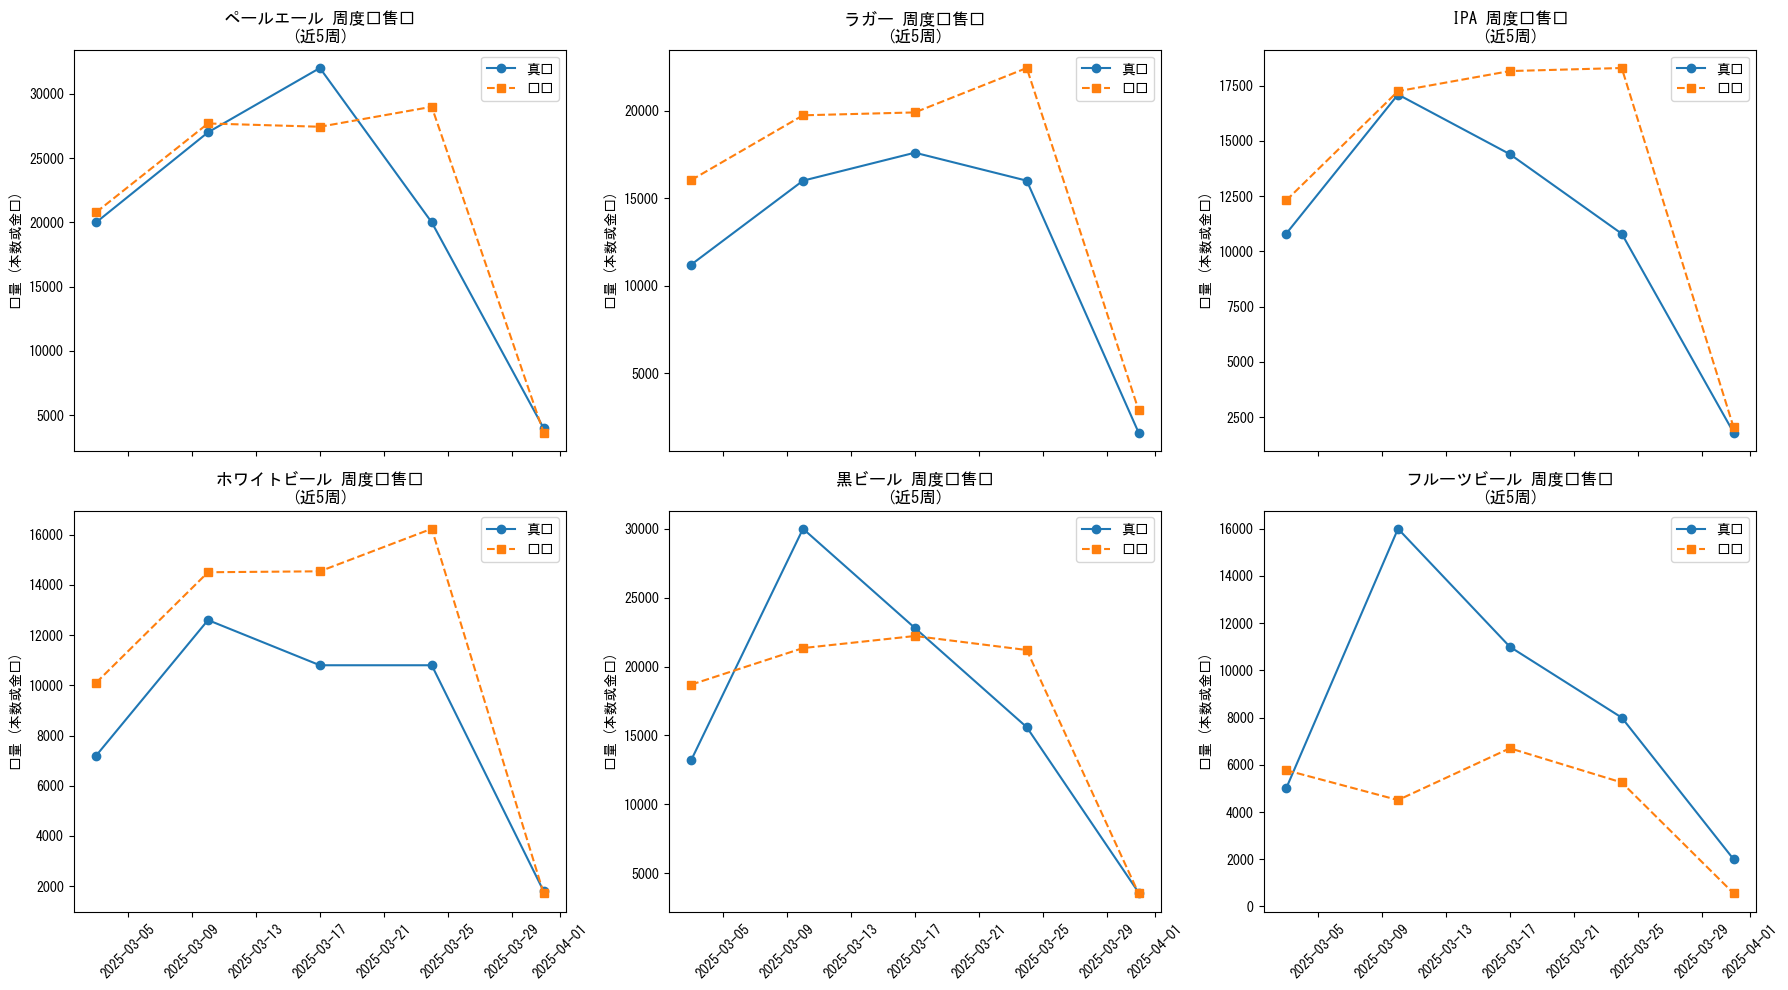

In [64]:
import matplotlib.pyplot as plt

# 假设之前已经算出了 weekly DataFrame，格式例如：
#               ペールエール_actual  ペールエール_pred  ラガー_actual  ラガー_pred  … 
# 2025-02-24           25000           23000            18000           17500
# 2025-03-03           27000           26000            20000           19500
# …

beer_types = ['ペールエール','ラガー','IPA','ホワイトビール','黒ビール','フルーツビール']

# 选取最后 5 周（大约 30 天）
last_weeks = weekly.iloc[-5:]

# 2×3 子图
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
for ax, beer in zip(axes.flatten(), beer_types):
    # 实际与预测列名
    act_col  = f'{beer}_actual'
    pred_col = f'{beer}_pred'
    
    ax.plot(last_weeks.index, last_weeks[act_col],  'o-', label='真实')
    ax.plot(last_weeks.index, last_weeks[pred_col], 's--', label='预测')
    ax.set_title(f"{beer} 周度销售额\n(近5周)")
    ax.set_ylabel("销量 (本数或金额)")
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


各啤酒品类日度预测 R² 决定系数：
   Beer        R2
 ペールエール  0.286110
    ラガー  0.478144
    IPA  0.269042
ホワイトビール  0.473632
   黒ビール  0.304792
フルーツビール -0.322745


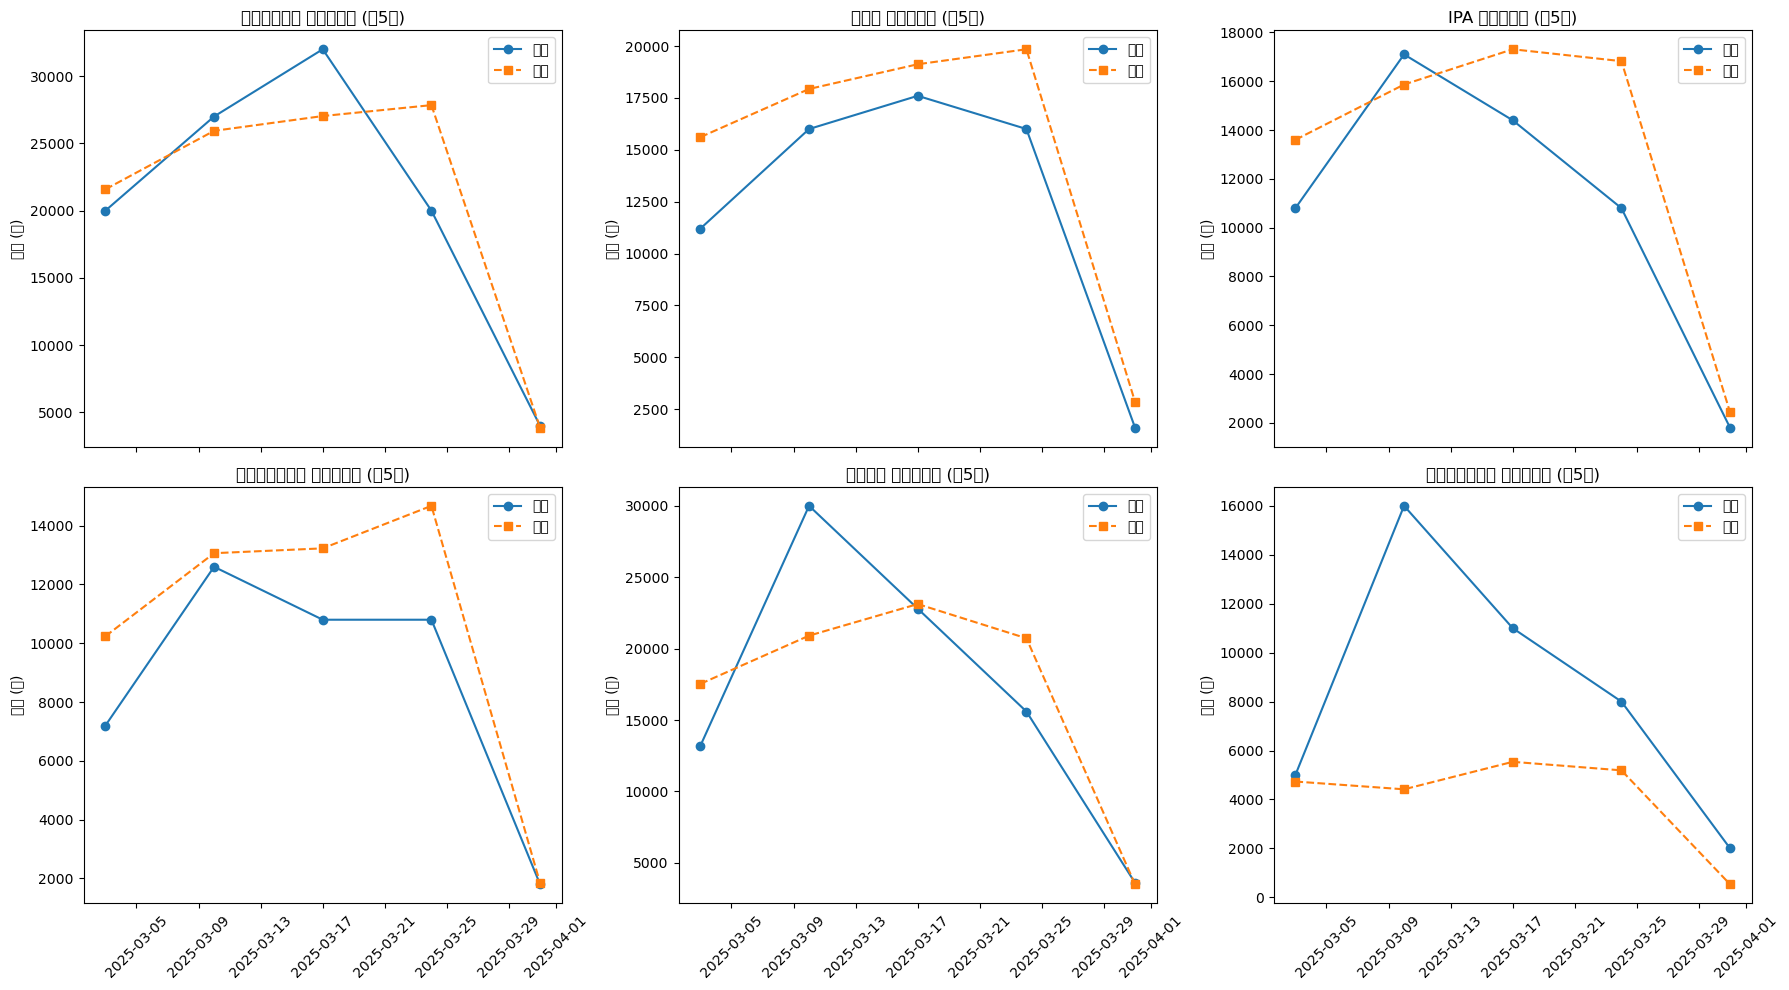

In [13]:
import catboost as cb
import warnings
import pandas as pd
import numpy as np
import jpholiday
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 如果还没安装 CatBoost，请先运行：
# pip install catboost

# ────────────────────────────────────────────────────────────
warnings.filterwarnings('ignore')  # 屏蔽无关警告

# 1. 读取日度数据并设置索引
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df.set_index('日付', inplace=True)

# 2. 构造通用日期与节假日特征
df['weekday']    = df.index.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['is_friday']  = (df['weekday'] == 4).astype(int)
df['is_holiday'] = df.index.to_series().apply(lambda d: int(jpholiday.is_holiday(d)))

# 3. 气象特征列
weather_cols = [
    '平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)',
    '平均湿度(％)', '最高気温(℃)', '最低気温(℃)',
    '10分間降水量の最大(mm)'
]

# 4. 周期性编码（星期 & 月份）
df['sin_wday'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['cos_wday'] = np.cos(2 * np.pi * df['weekday'] / 7)
df['month']    = df.index.month
df['sin_mon']  = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['cos_mon']  = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# 5. 啤酒品类列表
beer_types = ['ペールエール','ラガー','IPA','ホワイトビール','黒ビール','フルーツビール']

# 存放日度预测结果与 R² 汇总
daily_results = {}
r2_summary    = {}

# 6. 遍历每个品类：训练 CatBoost，预测最后 30 天
for beer in beer_types:
    target_col = f'{beer}(円)_x'
    log_col    = f'log_{beer}'
    df[log_col] = np.log1p(df[target_col])

    # 6.1 构造滞后与滚动特征
    lag_feats, roll_feats = [], []
    for L in [1,2,3,7]:
        c = f'{beer}_lag{L}'
        df[c] = df[target_col].shift(L)
        lag_feats.append(c)
    for W in [3,7,14]:
        c = f'{beer}_roll{W}'
        df[c] = df[target_col].rolling(W).mean().shift(1)
        roll_feats.append(c)

    # 6.2 准备训练特征列表
    feature_cols = [
        'weekday','is_weekend','is_friday','is_holiday',
        *weather_cols,
        'sin_wday','cos_wday','month','sin_mon','cos_mon',
        *lag_feats, *roll_feats
    ]

    # 6.3 删除缺失值
    df_model = df.dropna(subset=feature_cols + [log_col])
    X = df_model[feature_cols]
    y = df_model[log_col]

    # 6.4 划分训练/测试：最后30天作测试集
    X_train, X_test = X.iloc[:-30], X.iloc[-30:]
    y_train, y_test = y.iloc[:-30], y.iloc[-30:]

    # 6.5 初始化 CatBoost 回归器
    model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        random_seed=42,
        loss_function='RMSE',
        early_stopping_rounds=30,
        verbose=False
    )

    # 6.6 用时序 CV 测试性能（可选）
    # splits = list(TimeSeriesSplit(n_splits=5).split(X_train))
    # model.grid_search(...)

    # 6.7 训练并预测
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    y_pred_log = model.predict(X_test)
    y_pred     = np.expm1(y_pred_log)
    y_true     = np.expm1(y_test)

    # 6.8 存储日度预测结果
    daily_results[beer] = pd.DataFrame({
        f'{beer}_actual': y_true,
        f'{beer}_pred':   y_pred
    }, index=X_test.index)

    # 6.9 计算并记录 R²
    r2_summary[beer] = r2_score(y_true, y_pred)

# 7. 合并日度结果并汇总到周度
df_daily = pd.concat(daily_results.values(), axis=1)
weekly   = df_daily.resample('W-MON', label='left', closed='left').sum()

# 8. 打印 R² 决定系数汇总表
r2_df = pd.DataFrame.from_dict(r2_summary, orient='index', columns=['R2']).reset_index()
r2_df.columns = ['Beer', 'R2']
print("各啤酒品类日度预测 R² 决定系数：")
print(r2_df.to_string(index=False))

# 9. 可视化最后 5 周每周“真实 vs 预测”折线图
last_weeks = weekly.iloc[-5:]
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
for ax, beer in zip(axes.flatten(), beer_types):
    ax.plot(last_weeks.index, last_weeks[f'{beer}_actual'],  'o-', label='真实')
    ax.plot(last_weeks.index, last_weeks[f'{beer}_pred'],   's--', label='预测')
    ax.set_title(f"{beer} 周度销售额 (近5周)")
    ax.set_ylabel("金额 (円)")
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### LSTM

In [ ]:
import warnings
import pandas as pd
import numpy as np
import jpholiday
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# 1. 读取日度数据并设置索引
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df.set_index('日付', inplace=True)

# 2. 构造通用特征
df['weekday']    = df.index.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['is_friday']  = (df['weekday'] == 4).astype(int)
df['is_holiday'] = df.index.to_series().apply(lambda d: int(jpholiday.is_holiday(d)))

weather_cols = ['平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)',
                '平均湿度(％)', '最高気温(℃)', '最低気温(℃)',
                '10分間降水量の最大(mm)']

df['sin_wday'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['cos_wday'] = np.cos(2 * np.pi * df['weekday'] / 7)
df['month']    = df.index.month
df['sin_mon']  = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['cos_mon']  = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# 3. 啤酒品类列表
beer_types = ['ペールエール','ラガー','IPA','ホワイトビール','黒ビール','フルーツビール']

daily_results = {}
r2_summary = {}

# sequence length for LSTM
window_size = 14

for beer in beer_types:
    target = f'{beer}(円)_x'
    log_t  = f'log_{beer}'
    df[log_t] = np.log1p(df[target])
    
    # 构造滞后特征
    lag_feats = []
    for L in [1,2,3,7]:
        col = f'{beer}_lag{L}'
        df[col] = df[target].shift(L)
        lag_feats.append(col)
    
    # 特征列表
    features = ['weekday','is_weekend','is_friday','is_holiday'] + weather_cols + \
               ['sin_wday','cos_wday','month','sin_mon','cos_mon'] + lag_feats
    
    # 删除含缺失值行
    df_model = df.dropna(subset=features + [log_t])
    
    # 提取数据
    data_feat = df_model[features].values
    data_target = df_model[log_t].values
    
    # 标准化特征
    scaler = StandardScaler()
    feat_scaled = scaler.fit_transform(data_feat)
    
    # 构建时序样本
    X_all, y_all = [], []
    for i in range(window_size, len(feat_scaled)):
        X_all.append(feat_scaled[i-window_size:i])
        y_all.append(data_target[i])
    X_all = np.array(X_all)
    y_all = np.array(y_all)
    
    # 划分训练/测试
    n_test = 30
    n_total = len(y_all)
    test_start = n_total - n_test
    X_train, X_test = X_all[:test_start], X_all[test_start:]
    y_train, y_test = y_all[:test_start], y_all[test_start:]
    
    # 构建 LSTM 模型
    model = Sequential([
        LSTM(50, input_shape=(window_size, X_all.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # 训练
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )
    
    # 预测
    y_pred_log = model.predict(X_test).flatten()
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)
    
    # 存储日度结果
    dates = df_model.index[window_size:]
    daily_results[beer] = pd.DataFrame({
        f'{beer}_actual': y_true,
        f'{beer}_pred':   y_pred
    }, index=dates[-n_test:])
    
    # 记录 R²
    r2_summary[beer] = r2_score(y_true, y_pred)

# 合并日度结果并汇总到周度
df_daily = pd.concat(daily_results.values(), axis=1)
weekly = df_daily.resample('W-MON', label='left', closed='left').sum()

# 打印 R² 决定系数
r2_df = pd.DataFrame.from_dict(r2_summary, orient='index', columns=['R2']).reset_index()
r2_df.columns = ['Beer', 'R2']
print("各啤酒品类 LSTM 日度预测 R² 决定系数：")
print(r2_df.to_string(index=False))

# 可视化最后 5 周周度预测
last_weeks = weekly.iloc[-5:]
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
for ax, beer in zip(axes.flatten(), beer_types):
    ax.plot(last_weeks.index, last_weeks[f'{beer}_actual'],  'o-', label='真实')
    ax.plot(last_weeks.index, last_weeks[f'{beer}_pred'],   's--', label='预测')
    ax.set_title(f"{beer} 周度销售额 (近5周)")
    ax.set_ylabel("金额 (円)")
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
import warnings
import pandas as pd
import numpy as np
import jpholiday
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# 1. 读取日度数据并设置索引
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df.set_index('日付', inplace=True)

# 2. 构造通用特征
df['weekday']    = df.index.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['is_friday']  = (df['weekday'] == 4).astype(int)
df['is_holiday'] = df.index.to_series().apply(lambda d: int(jpholiday.is_holiday(d)))

weather_cols = ['平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)',
                '平均湿度(％)', '最高気温(℃)', '最低気温(℃)',
                '10分間降水量の最大(mm)']

df['sin_wday'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['cos_wday'] = np.cos(2 * np.pi * df['weekday'] / 7)
df['month']    = df.index.month
df['sin_mon']  = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['cos_mon']  = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# 3. 啤酒品类列表
beer_types = ['ペールエール','ラガー','IPA','ホワイトビール','黒ビール','フルーツビール']

daily_results = {}
r2_summary = {}

# sequence length for LSTM
window_size = 14

for beer in beer_types:
    target = f'{beer}(円)_x'
    log_t  = f'log_{beer}'
    df[log_t] = np.log1p(df[target])
    
    # 构造滞后特征
    lag_feats = []
    for L in [1,2,3,7]:
        col = f'{beer}_lag{L}'
        df[col] = df[target].shift(L)
        lag_feats.append(col)
    
    # 特征列表
    features = ['weekday','is_weekend','is_friday','is_holiday'] + weather_cols + \
               ['sin_wday','cos_wday','month','sin_mon','cos_mon'] + lag_feats
    
    # 删除含缺失值行
    df_model = df.dropna(subset=features + [log_t])
    
    # 提取数据
    data_feat = df_model[features].values
    data_target = df_model[log_t].values
    
    # 标准化特征
    scaler = StandardScaler()
    feat_scaled = scaler.fit_transform(data_feat)
    
    # 构建时序样本
    X_all, y_all = [], []
    for i in range(window_size, len(feat_scaled)):
        X_all.append(feat_scaled[i-window_size:i])
        y_all.append(data_target[i])
    X_all = np.array(X_all)
    y_all = np.array(y_all)
    
    # 划分训练/测试
    n_test = 30
    n_total = len(y_all)
    test_start = n_total - n_test
    X_train, X_test = X_all[:test_start], X_all[test_start:]
    y_train, y_test = y_all[:test_start], y_all[test_start:]
    
    # 构建 LSTM 模型
    model = Sequential([
        LSTM(50, input_shape=(window_size, X_all.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # 训练
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )
    
    # 预测
    y_pred_log = model.predict(X_test).flatten()
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)
    
    # 存储日度结果
    dates = df_model.index[window_size:]
    daily_results[beer] = pd.DataFrame({
        f'{beer}_actual': y_true,
        f'{beer}_pred':   y_pred
    }, index=dates[-n_test:])
    
    # 记录 R²
    r2_summary[beer] = r2_score(y_true, y_pred)

# 合并日度结果并汇总到周度
df_daily = pd.concat(daily_results.values(), axis=1)
weekly = df_daily.resample('W-MON', label='left', closed='left').sum()

# 打印 R² 决定系数
r2_df = pd.DataFrame.from_dict(r2_summary, orient='index', columns=['R2']).reset_index()
r2_df.columns = ['Beer', 'R2']
print("各啤酒品类 LSTM 日度预测 R² 决定系数：")
print(r2_df.to_string(index=False))

# 可视化最后 5 周周度预测
last_weeks = weekly.iloc[-5:]
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
for ax, beer in zip(axes.flatten(), beer_types):
    ax.plot(last_weeks.index, last_weeks[f'{beer}_actual'],  'o-', label='真实')
    ax.plot(last_weeks.index, last_weeks[f'{beer}_pred'],   's--', label='预测')
    ax.set_title(f"{beer} 周度销售额 (近5周)")
    ax.set_ylabel("金额 (円)")
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

